<a href="https://colab.research.google.com/github/tnwls6865/Creative_Masters/blob/main/week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creative Masters

## Google Drive와의 연동

금일 실습은 실제 데이터를 가지고 진행할 예정입니다. 하지만 저희는 현재 구글에서 제공하는 colab이라는 가상환경을 사용중이기 때문에 데이터를 쉽게 가져오도록 하기 위해서 구글 드라이브와 colab을 연동시켜보도록 하겠습니다.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

print('/content/gdrive 내 폴더 및 파일')
print(os.listdir('/content/gdrive'))

print()

print('/content/gdrive/MyDrive 내 폴더 및 파일')
print(os.listdir('/content/gdrive/MyDrive')[:5])

/content/gdrive 내 폴더 및 파일
['.file-revisions-by-id', 'MyDrive', '.shortcut-targets-by-id', '.Trash-0']

/content/gdrive/MyDrive 내 폴더 및 파일
['Colab Notebooks', '우분투 이동용', 'TranscodedWallpaper.png', '읽은 논문 정리.gdoc', 'parsed_data.json']


## 데이터셋 불러오기

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

저는 실습을 위해서 데이터를 다운받도록 하겠습니다. torchvision에 있는 download_url 함수를 사용하도록 하겠습니다. 이 함수는 URL만으로 데이터셋을 다운로드 받을 수 있게 해주는 함수입니다.

다운로드한 tgz 압축파일을 압축풀기 하도록 하겠습니다. 이를 위해 tarfile모듈을 사용하도록 하겠습니다.

In [ ]:
import tarfile
from torchvision.datasets.utils import download_url

# Dowload the dataset
# dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# download_url(dataset_url, '/content/gdrive/MyDrive')

# Extract from archive
# with tarfile.open('/content/gdrive/MyDrive/cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path='/content/gdrive/MyDrive/cifar10_data')

### with문 사용 설명

with의 사용과 관련해서는 예시를 들어 설명드리도록 하겠습니다.

프로그램시 자원의 활용은

1. 자원의 획득
2. 자원의 사용
3. 자원의 반납

순으로 이어집니다.

예를 들면 다음과 같습니다.

1. 파일을 열고, (자원의 획득)
2. 안의 내용을 사용하고, (자원의 사용)
3. 파일을 닫고. (자원의 반납)

실습을 위해 임의로 txt 파일을 만들어보도록 하겠습니다.

* with문을 사용하지 않는 경우

In [ ]:
# 자원의 획득
f = open("my_text_file.txt", "w")

# 자원의 사용
text = f.write('hello')

# 자원의 반납
f.close()

- with문을 사용하는 경우

(close를 쓰지 않아도 알아서 close가 됩니다.)

In [ ]:
with open("my_text_file.txt", "w") as f:
    text = f.write('hello')

### 데이터 살펴보기

데이터 세트는 제 드라이브의 cifar10 디렉토리로 추출됩니다. 여기에는 train 세트(50000개 이미지)와 test 세트(10000개 이미지)가 각각 포함된 train 및 test 폴더 2개가 포함되어 있습니다. 각각은 이미지의 각 클래스에 대해 하나씩 10개의 폴더를 포함합니다. os.listdir을 사용하여 이를 확인하도록 하겠습니다.

In [ ]:
data_dir = '/content/gdrive/MyDrive/cifar10_data/cifar10'

print(os.listdir(data_dir))

['test', 'train']


In [ ]:
classes = os.listdir(data_dir + "/train")
print(classes)

['bird', 'frog', 'dog', 'airplane', 'horse', 'truck', 'ship', 'deer', 'automobile', 'cat']


두 개의 폴더 내부를 살펴보겠습니다. 하나는 훈련 세트에서, 다른 하나는 테스트 세트에서 가져옵니다. 각 클래스에 동일한 수의 이미지(트레이닝 세트에 5000개, 테스트 세트에 1000개)가 있는지 확인할 수 있습니다.

In [ ]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 0
[]


In [ ]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 0
[]


저는 os.listdir보다는 glob 라이브러리의 glob함수를 더 선호합니다.

In [ ]:
from glob import glob

ship_test_files = glob(data_dir + "/test/ship/*.png")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 0
[]


위의 디렉토리 구조(클래스당 하나의 폴더)는 많은 컴퓨터 비전 데이터 세트에서 사용되며 대부분의 딥러닝 라이브러리는 이러한 데이터 세트 작업을 위한 유틸리티를 제공합니다. 우리는 데이터를 PyTorch 텐서로 로드하기 위해 torchvision의 ImageFolder 클래스를 사용할 수 있습니다.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

train 데이터 세트의 요소를 살펴보겠습니다. 각 요소는 이미지 텐서와 레이블을 포함하는 튜플입니다. 데이터는 3채널(RGB)의 32x32픽셀 컬러 이미지로 구성되어 있으므로 각 이미지 텐서의 모양은 (3, 32, 32)입니다.

In [ ]:
img, label = dataset[9978]
print(img.shape, label)
print(img)

matplotlib를 사용하여 이미지를 볼 수 있지만 텐서 차원을 (32,32,3)으로 변경해야 합니다.

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    # plt.imshow(img)
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
show_example(*dataset[0])

In [ ]:
show_example(*dataset[9999])

### 가변인자 (Variadic Parameters) 사용

종종 어떤 함수에서 가변인자를 필요로 할 때가 있습니다. 예를 들어, 들어오는 인자의 갯수를 모른다거나, 그 어떤 인자라도 모두 받아서 처리를 해야하는때가 있습니다.

파이썬에서는 인자의 종류가 2가지가 있는데 하나는 positional arguments이고, 하나는 keyword arguments입니다. 전자는 말그대로 위치에 따라 정해지는 인자이며, 후자는 키워드를 가진 즉, 이름을 가진 인자를 말합니다.

variadic positional/keyword arguments를 살펴보기 전에 간단하게 positional arguments과 keyword arguments에 대해 살펴보겠습니다.

In [ ]:
# 2~4명의 주자로 이루어진 달리기 대회 랭킹을 보여주는 함수
def save_ranking(first, second, third=None, fourth=None):
    rank = {}
    rank[1], rank[2] = first, second
    rank[3] = third if third is not None else 'Nobody'
    rank[4] = fourth if fourth is not None else 'Nobody'
    print(rank)

# positional arguments 2개 전달
save_ranking('ming', 'alice')
# positional arguments 2개와 keyword argument 1개 전달
save_ranking('alice', 'ming', third='mike')
# positional arguments 2개와 keyword arguments 2개 전달 (단, 하나는 positional argument 형태로 전달)
save_ranking('alice', 'ming', 'mike', fourth='jim')

위의 함수는 first, second라는 두 개의 positional arguments를 받으며 third, fourth라는 두 개의 keyword arguments를 받고 있습니다다. positional arguments의 경우 생략이 불가능하며 갯수대로 정해진 위치에 인자를 전달해야합니다. 그러나 keyword arguments의 경우 함수 선언시 디폴트값을 설정할 수 있으며, 만약 인자를 생략할 시 해당 디폴트값이 인자의 값으로 들어갑니다. 즉, 이 형태의 인자는 생략이 가능합니다. 따라서, 여기서 알 수 있는건 keyword arguments의 경우 생략이 가능하기 때문에, positional arguments 이전에 선언될 수는 없습니다. 즉, 다음의 코드는 에러를 발생시킵니다.

In [ ]:
def save_ranking(first, second=None, third, fourth=None):
    rank = {}
    rank[1], rank[2] = first, second
    rank[3] = third if third is not None else 'Nobody'
    rank[4] = fourth if fourth is not None else 'Nobody'
    print(rank)

그런데, 여기서 한 가지 문제를 맞닥뜨릴 수 있습니다. 만약, 최대 4명의 주자가 아닌 10명 또는 그 이상의 정해지지 않은 주자가 있다고 가정하겠습니다. 이 경우엔 10개의 인자를 선언하기도 번거로우며, 특히, 주자의 수가 미정일 경우 위와 같은 형태로는 처리가 불가능합니다. 이 때 사용하는게 바로 **가변인자 (Variadic Arguments)**입니다. 가변인자는 좀 전에 위에서 설명한 positional arguments와 keyword arguments에 모두 사용할 수 있으며, 사용 방법은 다음과 같습니다.

In [ ]:
# positional arguments만 받을 때
def save_ranking(*args):
    print(args)
save_ranking('ming', 'alice', 'tom', 'wilson', 'roy')

In [ ]:
# keyword arguments만 받을 때
def save_ranking(**kwargs):
    print(kwargs)
save_ranking(first='ming', second='alice', fourth='wilson', third='tom', fifth='roy')

### 본인의 Dataset 활용

저는 실습을 위해서 벤치마크 데이터인 CIFAR-10 데이터를 다운받아서 사용했습니다. 하지만 위와 같은 방식으로 본인만의 데이터를 사용할 수도 있습니다.

In [ ]:
custom_dataset = ImageFolder('/content/gdrive/MyDrive/custom/train', transform=ToTensor())

In [ ]:
custom_img, custom_label = custom_dataset[0]
print(custom_img.shape, custom_label)
print(custom_img)

In [ ]:
show_example(*custom_dataset[0])

### Training and Validation Datasets

실제 기계 학습 모델을 학습할 때 데이터 세트를 세 파트로 나누는 것이 일반적입니다.

* Training 세트 - 모델을 학습하는 데 사용됩니다. 즉, 경사 하강법을 사용하여 loss를 계산하고 모델의 가중치를 조정합니다.
* Validation 세트 - 훈련하는 동안 모델을 평가하고 하이퍼파라미터를 조정하여 모델의 최상의 버전을 선택하는 데 사용됩니다.
* Test 세트 - 다양한 모델 또는 다양한 유형의 접근 방식을 비교하고 모델의 최종 정확도를 보고하는 데 사용됩니다.

미리 정의된 Validation 세트가 없기 때문에 Validation 세트로 사용할 Training 세트의 일부분(5000개 을미지)을 별도로 설정하도록 하겠습니다. 이를 위해 PyTorch의 random_split을 사용합니다.

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

print(train_size)

컴퓨터 프로그램에서 발생하는 무작위 수는 사실 엄격한 의미의 무작위 수가 아닙니다. 어떤 특정한 시작 숫자를 정해 주면 컴퓨터가 정해진 알고리즘에 의해 마치 난수처럼 보이는 수열을 생성합니다. 이런 시작 숫자를 시드(seed)라고 합니다. 일단 생성된 난수는 다음번 난수 생성을 위한 시드값이 됩니다. 따라서 시드값은 한 번만 정해주면 됩니다. 시드는 보통 현재 시각등을 이용하여 자동으로 정해지지만 사람이 수동으로 설정할 수도 있습니다. 특정한 시드값이 사용되면 그 다음에 만들어지는 난수들은 모두 예측할 수 있습니다.

In [ ]:
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

이제 Training 및 Validation을 위한 DataLoader를 생성하여 데이터를 배치로 로드할 수 있습니다.

- PyTorch Korea 공식문서 설명

데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보수가 어려울 수 있습니다; 더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적입니다. PyTorch는 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 합니다. Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4)

In [ ]:
for batch in train_dl:
    print(batch)
    break

### Linear 모델

Linear로 3개 층을 쌓아서 한번 모델을 만들어 보겠습니다. nn.Module을 하위 클래스로 분류하여 신경망을 정의하고 __init__에서 신경망 계층을 초기화합니다. 모든 nn.Module 하위 클래스는 전달 메서드의 입력 데이터에 대한 작업을 구현합니다. (이전 실습 내용과 동일합니다.)

가능한 경우 GPU와 같은 하드웨어 가속기에서 모델을 훈련하는 것이 좋습니다. torch.cuda를 사용할 수 있는지 확인하고 그렇지 않으면 CPU를 계속 사용하는 코드를 작성합니다.

In [ ]:
import torch
from torch import nn

# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

모델을 사용하기 위해 입력 데이터를 전달합니다. 그러면 일부 백그라운드 작업과 함께 모델의 전달이 실행됩니다. model.forward()를 직접 호출하지 않으셔도 됩니다.

입력에서 모델을 호출하면 각 클래스에 대한 10개의 원시 예측 값의 각 출력에 해당하는 dim=0과 각 출력의 개별 값에 해당하는 dim=1인 2차원 텐서를 반환합니다. nn.Softmax 모듈의 인스턴스를 통과하여 예측 확률을 얻습니다.

In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

### 모델 학습

loss함수와 optimzier를 설정해줍니다.

또한 learning rate와 같은 hyper-parameter도 설정해줍니다.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train 함수와 test 함수를 설정해보겠습니다.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    loss_history_list = list()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_history_list.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss_history_list

보통 딥러닝에서는 미니배치+루프 조합을 사용해서 parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 됩니다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안되게 됩니다.

따라서 루프가 한번 돌고나서 역전파를 하기전에 반드시 zero_grad()로 .grad 값들을 0으로 초기화시킨 후 학습을 진행해야 합니다.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

* with torch.no_grad()

no_grad() with statement에 포함시키게 되면 Pytorch는 autograd engine을 꺼버립니다. 이 말은 더 이상 자동으로 gradient를 트래킹하지 않는다는 말이 됩니다. 

torch.no_grad()의 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높히기 위함입니다. 

* model.eval()

위의 torch.no_grad()만 쓰면 되지 않나? gradient 계산 안하고 이제 됐잖아 라고 생각할 수 있습니다. 맞는 말이지만, model.eval()의 역할은 약간 다릅니다. PyTorch에서는 모델링 시 training과 inference시에 다르게 동작하는 layer들이 존재합니다. 예를 들면, Dropout layer는 학습시에는 동작해야하지만, inference시에는 동작하지 않는 것과 같은 예시를 들 수 있습니다. BatchNorm같은 경우도 마찬가지다.

사실상 model.eval()는 이런 layer들의 동작을 inference(eval) mode로 바꿔준다는 목적으로 사용됩니다. 따라서, 우리가 보통 원하는 모델의 동작을 위해서는 위의 두 가지를 모두 사용해야하는 것이 맞습니다.

이제 본격적으로 학습을 진행하도록 하겠습니다.

In [ ]:
epochs = 10
train_loss_list, valid_loss_list, valid_acc_list = list(), list(), list()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_history_list = train(train_dl, model, loss_fn, optimizer)
    valid_loss, accuracy = test(val_dl, model, loss_fn)
    train_loss_list.extend(train_loss_history_list)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(accuracy)
print("Done!")

### 평가 (Evaluation)

우리의 모델은 약 70%의 정확도에 도달하는데, 그래프를 보면 오랜 시간 훈련을 해도 모델이 80% 이상의 정확도를 달성할 가능성은 없어 보입니다. 이는 이미지와 라벨 간의 관계를 보다 정확하게 포착하기 위해 보다 강력한 모델을 사용해야 할 수도 있음을 시사합니다. 모델에 컨볼루션 레이어를 추가하거나 각 컨볼루션 레이어의 채널 수를 늘리거나 regularization 기술을 사용하는 등 다양한 방식을 수행해볼 수 있습니다.

In [ ]:
def plot_loss(history):
    plt.plot(history, '-x')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('[Train]Loss vs. No. of iteration');

plot_loss(train_loss_list)

In [ ]:
plot_loss(valid_loss_list)

In [ ]:
new_train_loss_list = list()

for i,x in enumerate(train_loss_list):
    if i % 4 == 0:
        new_train_loss_list.append(x)

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(new_train_loss_list, valid_loss_list)

처음에는 훈련 및 검증 손실이 모두 시간이 지남에 따라 감소하는 것으로 보입니다. 그러나 모델을 충분히 오래 훈련하면 훈련 손실이 계속 감소하는 반면 유효성 검사 손실은 감소를 멈추고 특정 시점 이후에는 증가하기 시작합니다.

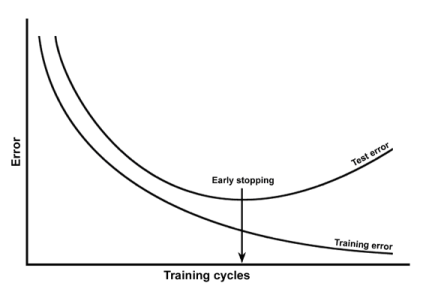

이러한 현상을 과적합이라고 하며, 많은 기계 학습 모델이 실제 데이터에 대해 좋지 않은 결과를 제공하는 대표적인 이유입니다. 모델이 손실을 최소화하기 위해 학습 데이터에 고유한 패턴을 학습하기 시작하고 때로는 특정 학습 예제를 기억하기 때문에 발생합니다. 이 때문에 모델은 이전에 본 적이 없는 데이터로 잘 일반화되지 않습니다.

다음은 과적합을 방지하기 위한 몇 가지 일반적인 전략입니다.

* 더 많은 Training 데이터를 수집 및 생성하거나 데이터에 노이즈 추가
* Batch normalization 및 Dropout과 같은 Regularization 기술 사용
* Evaluation loss가 증가하기 시작하면 모델 학습을 조기에 중지합니다.

### Testing

지금까지 모델의 전반적인 정확도를 추적했지만 일부 샘플 이미지에서 모델의 결과를 살펴보는 것도 좋은 방법입니다. 미리 정의된 10000개 이미지의 테스트 데이터 세트에서 일부 이미지로 모델을 테스트해 보겠습니다. ImageFolder 클래스를 사용하여 테스트 데이터 세트를 만드는 것으로 시작합니다.

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

그리고 함수를 정의하여 단일 이미지 텐서에서의 확인을 용이하게 해보도록 하겠습니다.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

### Convolutional Neural Network

Conv2d 레이어는 3채널 이미지를 16채널 feature map으로 변환하고 MaxPool2d 레이어는 높이와 너비를 줄입니다. feature map은 더 많은 레이어를 추가함에 따라 점점 작아지고 후에는 평면화(flatten)할 수 있는 작은 피처 맵이 남게 됩니다. 그다음 fully-connected 레이어를 추가하여 각 이미지에 대해 크기 10의 벡터를 얻을 수 있습니다.

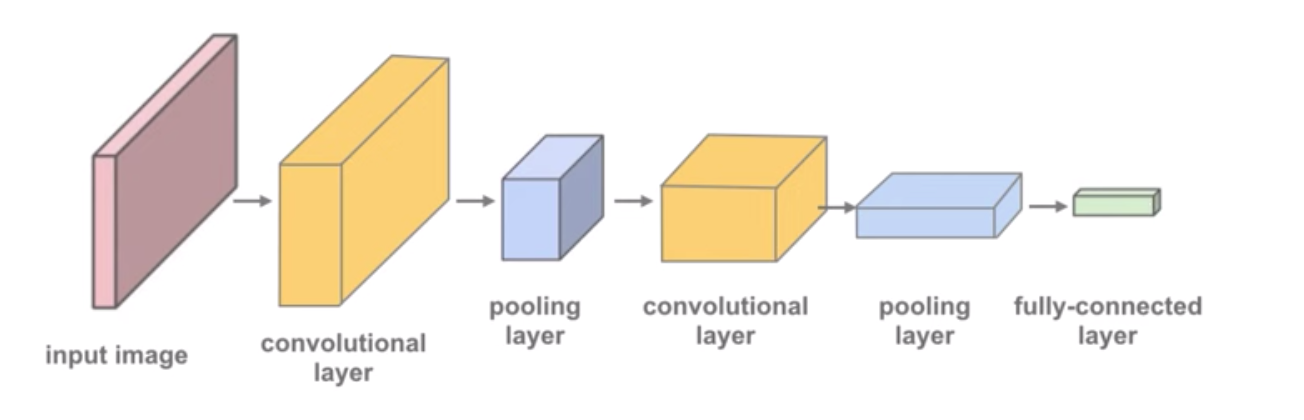

In [ ]:
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
print(model)

이제 새로이 짠 CNN모델로 학습을 진행해보도록 하겠습니다.

In [ ]:
epochs = 10
train_loss_list, valid_loss_list, valid_acc_list = list(), list(), list()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_history_list = train(train_dl, model, loss_fn, optimizer)
    valid_loss, accuracy = test(val_dl, model, loss_fn)
    train_loss_list.extend(train_loss_history_list)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(accuracy)
print("Done!")

In [ ]:
plot_loss(train_loss_list)

In [ ]:
plot_loss(valid_loss_list)

In [ ]:
#@title
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

### Testing (Custom Data)

마지막으로 인터넷에 있는 다른 이미지를 통해서 CIFAR10 데이터뿐만 아니라 다른 데이터에서도 잘 동작하는지 살펴보겠습니다.

In [ ]:
from PIL import Image

# 다운받을 이미지 url
url = "https://dzqerse1lankl.cloudfront.net/carsdata/cars/cm_cardb/file/3bebfa8e-8a58-48be-9127-61751389b007.jpg"

# curl 요청
os.system("curl " + url + " > car.jpg")

# 저장 된 이미지 확인
img = Image.open("car.jpg").convert('RGB')
img

In [ ]:
import torchvision.transforms as transforms

# set up transformation to resize the image
resize = transforms.Resize([32, 32])
img = resize(img)
to_tensor = transforms.ToTensor()
tensor = to_tensor(img)

print(tensor.size())

# add another dimension at the front to get NCHW shape
img_tensor = tensor.unsqueeze(0)
print(tensor.size())

In [ ]:
import torchvision.transforms as transforms

# set up transformation to resize the image
resize = transforms.Resize([32, 32])
img = resize(img)
to_tensor = transforms.ToTensor()
tensor = to_tensor(img)

print(tensor.size())

# add another dimension at the front to get NCHW shape
img_tensor = tensor.unsqueeze(0)
print(tensor.size())

In [ ]:
plt.imshow(tensor.permute(1, 2, 0))
out = model(img_tensor.to(device))
_, preds  = torch.max(out, dim=1)
print(f'Predicted: {dataset.classes[preds[0].item()]}')